# KE5105 - Building Electrical Consumption Forecasting

# Modelling 6 - Preliminary model

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

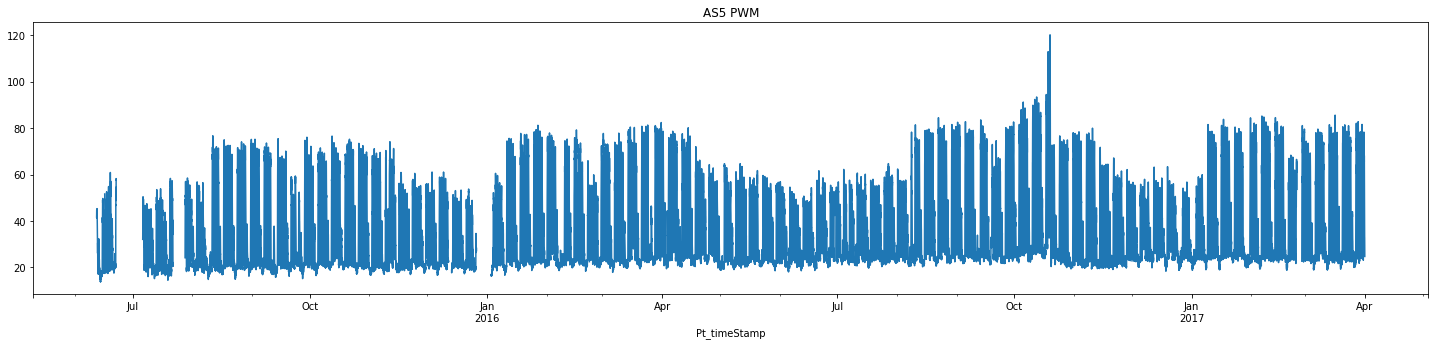

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

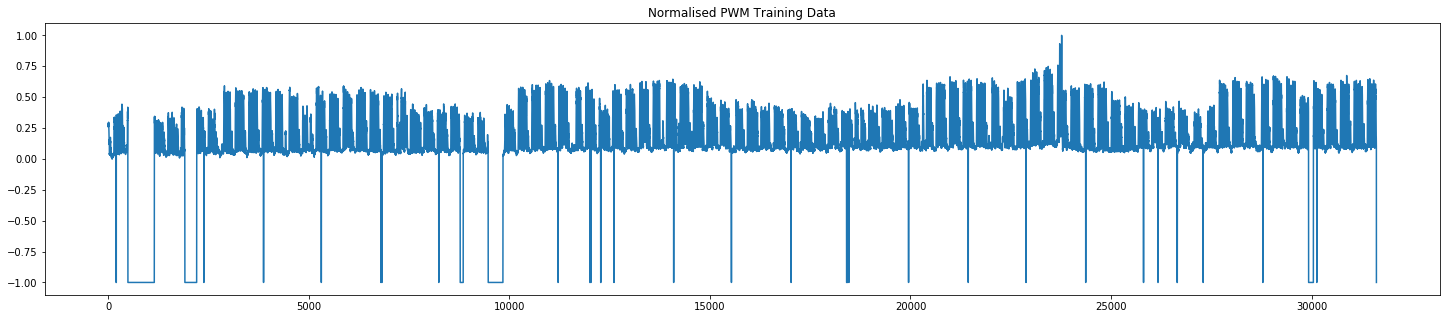

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

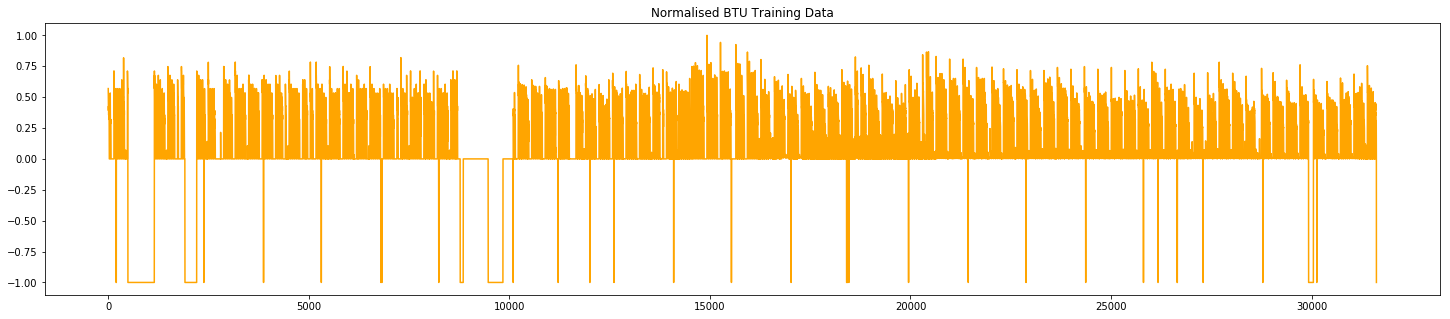

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Layer Model 

In [19]:
model = Sequential()
model.add(layers.GRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.GRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
gen_train.__len__()

143

In [22]:
gen_val.__len__()

88

### Train the RNN

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=70,
                              validation_data=gen_val,
                              workers=1, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/70


 - 96s - loss: 0.0648 - mean_absolute_percentage_error: 41.2051 - val_loss: 0.0371 - val_mean_absolute_percentage_error: 24.7837


Epoch 2/70


 - 93s - loss: 0.0399 - mean_absolute_percentage_error: 26.0473 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 19.6340


Epoch 3/70


 - 95s - loss: 0.0332 - mean_absolute_percentage_error: 22.9256 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 14.8184


Epoch 4/70


 - 98s - loss: 0.0311 - mean_absolute_percentage_error: 21.5098 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 19.5822


Epoch 5/70


 - 97s - loss: 0.0284 - mean_absolute_percentage_error: 19.6469 - val_loss: 0.0350 - val_mean_absolute_percentage_error: 13.1161


Epoch 6/70


 - 94s - loss: 0.0275 - mean_absolute_percentage_error: 18.3309 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 17.3517


Epoch 7/70


 - 94s - loss: 0.0263 - mean_absolute_percentage_error: 17.6853 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 15.6715


Epoch 8/70


 - 94s - loss: 0.0252 - mean_absolute_percentage_error: 16.8453 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 14.1657


Epoch 9/70


 - 94s - loss: 0.0245 - mean_absolute_percentage_error: 16.6920 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 12.5467


Epoch 10/70


 - 94s - loss: 0.0241 - mean_absolute_percentage_error: 16.2712 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 10.1851


Epoch 11/70


 - 95s - loss: 0.0233 - mean_absolute_percentage_error: 15.4049 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 20.1115


Epoch 12/70


 - 94s - loss: 0.0230 - mean_absolute_percentage_error: 15.6538 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 10.1808


Epoch 13/70


 - 93s - loss: 0.0229 - mean_absolute_percentage_error: 15.3092 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 12.1245


Epoch 14/70


 - 93s - loss: 0.0227 - mean_absolute_percentage_error: 15.3287 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 14.1837


Epoch 15/70


 - 93s - loss: 0.0222 - mean_absolute_percentage_error: 14.8820 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.9232


Epoch 16/70


 - 93s - loss: 0.0224 - mean_absolute_percentage_error: 15.3732 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 10.2995


Epoch 17/70


 - 93s - loss: 0.0217 - mean_absolute_percentage_error: 14.9065 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 10.2529


Epoch 18/70


 - 93s - loss: 0.0215 - mean_absolute_percentage_error: 14.1551 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 12.4096


Epoch 19/70


 - 94s - loss: 0.0212 - mean_absolute_percentage_error: 14.4843 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.4094


Epoch 20/70


 - 94s - loss: 0.0212 - mean_absolute_percentage_error: 14.4080 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 15.4300


Epoch 21/70


 - 93s - loss: 0.0207 - mean_absolute_percentage_error: 14.0368 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.6726


Epoch 22/70


 - 93s - loss: 0.0209 - mean_absolute_percentage_error: 13.7613 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 10.1767


Epoch 23/70


 - 93s - loss: 0.0207 - mean_absolute_percentage_error: 14.1787 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 12.8239


Epoch 24/70


 - 93s - loss: 0.0204 - mean_absolute_percentage_error: 13.7484 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 10.1010


Epoch 25/70


 - 93s - loss: 0.0205 - mean_absolute_percentage_error: 13.6069 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.3303


Epoch 26/70


 - 95s - loss: 0.0204 - mean_absolute_percentage_error: 13.4736 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 13.0094


Epoch 27/70


 - 96s - loss: 0.0202 - mean_absolute_percentage_error: 13.3596 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 11.2424


Epoch 28/70


 - 96s - loss: 0.0200 - mean_absolute_percentage_error: 13.7343 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 10.3374


Epoch 29/70


 - 95s - loss: 0.0199 - mean_absolute_percentage_error: 13.6005 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 12.8163


Epoch 30/70


 - 94s - loss: 0.0200 - mean_absolute_percentage_error: 13.5281 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 14.6526


Epoch 31/70


 - 95s - loss: 0.0196 - mean_absolute_percentage_error: 13.4089 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 10.0159


Epoch 32/70


 - 95s - loss: 0.0196 - mean_absolute_percentage_error: 13.4532 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 10.5585


Epoch 33/70


 - 94s - loss: 0.0193 - mean_absolute_percentage_error: 13.2369 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.1381


Epoch 34/70


 - 94s - loss: 0.0198 - mean_absolute_percentage_error: 13.5614 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 12.4783


Epoch 35/70


 - 93s - loss: 0.0193 - mean_absolute_percentage_error: 12.7725 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 9.6142


Epoch 36/70


 - 95s - loss: 0.0190 - mean_absolute_percentage_error: 12.8628 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 11.7287


Epoch 37/70


 - 94s - loss: 0.0190 - mean_absolute_percentage_error: 12.9505 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 10.0226


Epoch 38/70


 - 93s - loss: 0.0189 - mean_absolute_percentage_error: 12.6214 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.6196


Epoch 39/70


 - 94s - loss: 0.0188 - mean_absolute_percentage_error: 12.7518 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 8.8348


Epoch 40/70


 - 93s - loss: 0.0187 - mean_absolute_percentage_error: 12.6793 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 12.1324


Epoch 41/70


 - 94s - loss: 0.0184 - mean_absolute_percentage_error: 12.8121 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 10.0070


Epoch 42/70


 - 95s - loss: 0.0184 - mean_absolute_percentage_error: 12.6185 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 10.3719


Epoch 43/70


 - 94s - loss: 0.0182 - mean_absolute_percentage_error: 12.6191 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.5423


Epoch 44/70


 - 95s - loss: 0.0181 - mean_absolute_percentage_error: 12.4265 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 11.0160


Epoch 45/70


 - 96s - loss: 0.0180 - mean_absolute_percentage_error: 12.5202 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.9126


Epoch 46/70


 - 96s - loss: 0.0181 - mean_absolute_percentage_error: 12.4898 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 10.5884


Epoch 47/70


 - 96s - loss: 0.0180 - mean_absolute_percentage_error: 12.3616 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 11.7239


Epoch 48/70


 - 95s - loss: 0.0179 - mean_absolute_percentage_error: 12.3564 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 10.2219


Epoch 49/70


 - 94s - loss: 0.0176 - mean_absolute_percentage_error: 11.8013 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 10.3519


Epoch 50/70


 - 94s - loss: 0.0172 - mean_absolute_percentage_error: 11.8829 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 9.3215


Epoch 51/70


 - 94s - loss: 0.0175 - mean_absolute_percentage_error: 12.1765 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 8.7870


Epoch 52/70


 - 94s - loss: 0.0171 - mean_absolute_percentage_error: 11.9887 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 12.6268


Epoch 53/70


 - 94s - loss: 0.0172 - mean_absolute_percentage_error: 11.8790 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.3447


Epoch 54/70


 - 94s - loss: 0.0172 - mean_absolute_percentage_error: 11.9201 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.3693


Epoch 55/70


 - 94s - loss: 0.0170 - mean_absolute_percentage_error: 11.6217 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.2745


Epoch 56/70


 - 94s - loss: 0.0168 - mean_absolute_percentage_error: 11.6389 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 9.5894


Epoch 57/70


 - 94s - loss: 0.0167 - mean_absolute_percentage_error: 11.6067 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.3927


Epoch 58/70


 - 94s - loss: 0.0168 - mean_absolute_percentage_error: 11.5147 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 9.4853


Epoch 59/70


 - 94s - loss: 0.0168 - mean_absolute_percentage_error: 11.7512 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.0263


Epoch 60/70


 - 94s - loss: 0.0164 - mean_absolute_percentage_error: 11.5575 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 10.5427


Epoch 61/70


 - 94s - loss: 0.0164 - mean_absolute_percentage_error: 11.1327 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 8.9296


Epoch 62/70


 - 95s - loss: 0.0162 - mean_absolute_percentage_error: 11.2390 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 10.5095


Epoch 63/70


 - 94s - loss: 0.0162 - mean_absolute_percentage_error: 11.1290 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 10.2775


Epoch 64/70


 - 95s - loss: 0.0162 - mean_absolute_percentage_error: 11.1551 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 8.9354


Epoch 65/70


 - 94s - loss: 0.0160 - mean_absolute_percentage_error: 11.1390 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.0951


Epoch 66/70


 - 94s - loss: 0.0159 - mean_absolute_percentage_error: 10.8502 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 9.0734


Epoch 67/70


 - 94s - loss: 0.0158 - mean_absolute_percentage_error: 10.9245 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.9530


Epoch 68/70


 - 93s - loss: 0.0158 - mean_absolute_percentage_error: 10.7354 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.8066


Epoch 69/70


 - 94s - loss: 0.0157 - mean_absolute_percentage_error: 10.9888 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 8.2713


Epoch 70/70


 - 96s - loss: 0.0157 - mean_absolute_percentage_error: 10.9018 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.3409



Training Duration = 1:49:56.983744


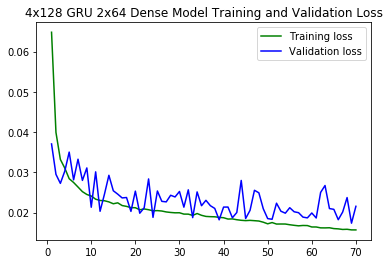

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x128 GRU 2x32 Dense Model Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.669026
Validation MAE = 1.846923


In [30]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=1, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [32]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

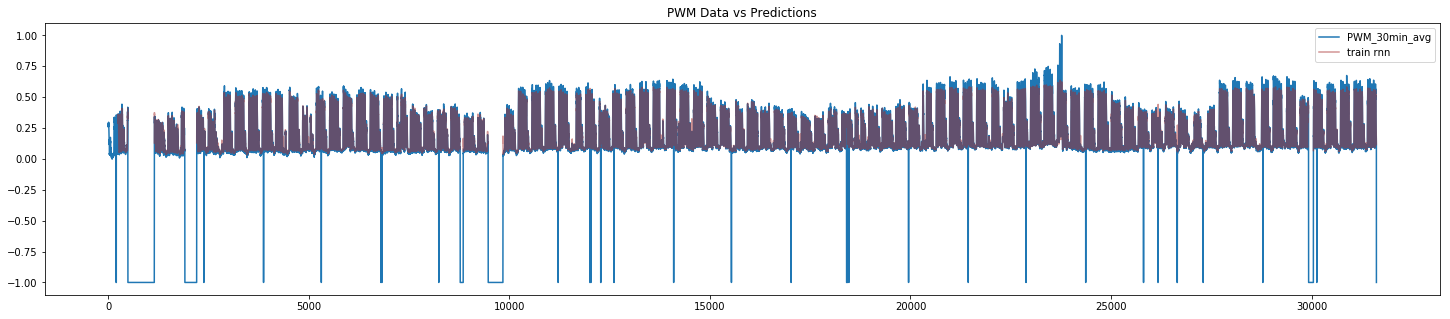

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

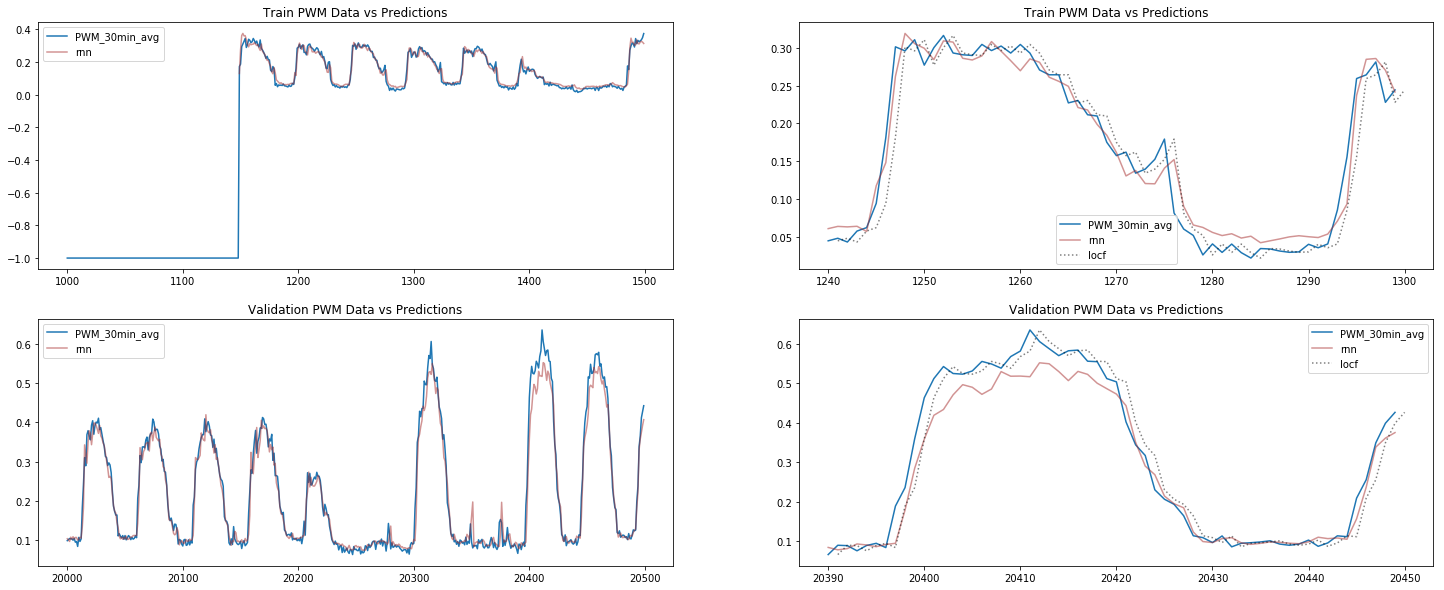

In [35]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [36]:
model.save('base-4x128gru-2x32dense-nomask-val.h5')

In [37]:
with open('base-4x128gru-2x32dense-nomask-val-history.pkl', 'wb') as outfile:
    pickle.dump(history.history, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
gen_train.__len__()

143

In [22]:
gen_val.__len__()

88

In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-history.pkl'), 'rb') as infile:
    history = pickle.load(infile)
histories = []
histories.append(history)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout.h5'))
model.summary()

In [45]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50

 - 94s - loss: 0.0184 - mean_absolute_percentage_error: 12.4129 - val_loss: 0.0495 - val_mean_absolute_percentage_error: 21.6401


Epoch 2/50


 - 93s - loss: 0.0183 - mean_absolute_percentage_error: 12.2700 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 18.0239


Epoch 3/50


 - 93s - loss: 0.0184 - mean_absolute_percentage_error: 12.3692 - val_loss: 0.0411 - val_mean_absolute_percentage_error: 18.3144


Epoch 4/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.2837 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 17.1902


Epoch 5/50


 - 93s - loss: 0.0183 - mean_absolute_percentage_error: 12.3216 - val_loss: 0.0439 - val_mean_absolute_percentage_error: 17.7521


Epoch 6/50


 - 93s - loss: 0.0182 - mean_absolute_percentage_error: 12.2927 - val_loss: 0.0473 - val_mean_absolute_percentage_error: 19.8470


Epoch 7/50


 - 93s - loss: 0.0181 - mean_absolute_percentage_error: 12.1725 - val_loss: 0.0456 - val_mean_absolute_percentage_error: 18.5817


Epoch 8/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.2131 - val_loss: 0.0372 - val_mean_absolute_percentage_error: 16.0326


Epoch 9/50


 - 93s - loss: 0.0180 - mean_absolute_percentage_error: 12.1874 - val_loss: 0.0531 - val_mean_absolute_percentage_error: 25.4666


Epoch 10/50


 - 93s - loss: 0.0185 - mean_absolute_percentage_error: 12.4049 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 17.0128


Epoch 11/50


 - 94s - loss: 0.0184 - mean_absolute_percentage_error: 12.2703 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 22.2575


Epoch 12/50


 - 94s - loss: 0.0183 - mean_absolute_percentage_error: 12.4125 - val_loss: 0.0466 - val_mean_absolute_percentage_error: 20.0208


Epoch 13/50


 - 92s - loss: 0.0185 - mean_absolute_percentage_error: 12.3864 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 20.2903


Epoch 14/50


 - 92s - loss: 0.0182 - mean_absolute_percentage_error: 12.1818 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 13.4802


Epoch 15/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.1235 - val_loss: 0.0513 - val_mean_absolute_percentage_error: 22.8080


Epoch 16/50


 - 92s - loss: 0.0180 - mean_absolute_percentage_error: 12.1314 - val_loss: 0.0448 - val_mean_absolute_percentage_error: 17.6384


Epoch 17/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.1121 - val_loss: 0.0493 - val_mean_absolute_percentage_error: 25.6860


Epoch 18/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.1939 - val_loss: 0.0508 - val_mean_absolute_percentage_error: 24.2912


Epoch 19/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 12.0166 - val_loss: 0.0437 - val_mean_absolute_percentage_error: 17.8212


Epoch 20/50


 - 92s - loss: 0.0181 - mean_absolute_percentage_error: 12.1281 - val_loss: 0.0524 - val_mean_absolute_percentage_error: 22.5249


Epoch 21/50


 - 92s - loss: 0.0179 - mean_absolute_percentage_error: 12.1751 - val_loss: 0.0451 - val_mean_absolute_percentage_error: 19.1311


Epoch 22/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0985 - val_loss: 0.0459 - val_mean_absolute_percentage_error: 21.7084


Epoch 23/50


 - 92s - loss: 0.0177 - mean_absolute_percentage_error: 11.9150 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 18.6704


Epoch 24/50


 - 93s - loss: 0.0179 - mean_absolute_percentage_error: 12.0624 - val_loss: 0.0530 - val_mean_absolute_percentage_error: 21.5533


Epoch 25/50


 - 92s - loss: 0.0181 - mean_absolute_percentage_error: 12.0585 - val_loss: 0.0484 - val_mean_absolute_percentage_error: 24.0887


Epoch 26/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.1604 - val_loss: 0.0441 - val_mean_absolute_percentage_error: 19.2965


Epoch 27/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0022 - val_loss: 0.0352 - val_mean_absolute_percentage_error: 16.7145


Epoch 28/50


 - 92s - loss: 0.0180 - mean_absolute_percentage_error: 12.0087 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 18.1758


Epoch 29/50


 - 92s - loss: 0.0179 - mean_absolute_percentage_error: 11.8931 - val_loss: 0.0477 - val_mean_absolute_percentage_error: 20.1646


Epoch 30/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.7059 - val_loss: 0.0460 - val_mean_absolute_percentage_error: 23.2795


Epoch 31/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8132 - val_loss: 0.0443 - val_mean_absolute_percentage_error: 21.6463


Epoch 32/50


 - 92s - loss: 0.0177 - mean_absolute_percentage_error: 11.7756 - val_loss: 0.0383 - val_mean_absolute_percentage_error: 15.1824


Epoch 33/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 11.9731 - val_loss: 0.0538 - val_mean_absolute_percentage_error: 24.5379


Epoch 34/50


 - 93s - loss: 0.0175 - mean_absolute_percentage_error: 11.9671 - val_loss: 0.0495 - val_mean_absolute_percentage_error: 21.5396


Epoch 35/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8297 - val_loss: 0.0449 - val_mean_absolute_percentage_error: 21.1778


Epoch 36/50


 - 93s - loss: 0.0175 - mean_absolute_percentage_error: 12.0002 - val_loss: 0.0462 - val_mean_absolute_percentage_error: 19.8544


Epoch 37/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.6635 - val_loss: 0.0436 - val_mean_absolute_percentage_error: 20.1899


Epoch 38/50


 - 92s - loss: 0.0178 - mean_absolute_percentage_error: 12.0100 - val_loss: 0.0394 - val_mean_absolute_percentage_error: 16.2103


Epoch 39/50


 - 93s - loss: 0.0178 - mean_absolute_percentage_error: 11.9251 - val_loss: 0.0457 - val_mean_absolute_percentage_error: 18.8444


Epoch 40/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.7774 - val_loss: 0.0473 - val_mean_absolute_percentage_error: 19.2457


Epoch 41/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.9046 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 21.6150


Epoch 42/50


 - 92s - loss: 0.0174 - mean_absolute_percentage_error: 11.6434 - val_loss: 0.0425 - val_mean_absolute_percentage_error: 19.2412


Epoch 43/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.7934 - val_loss: 0.0527 - val_mean_absolute_percentage_error: 25.5111


Epoch 44/50


 - 92s - loss: 0.0175 - mean_absolute_percentage_error: 11.8624 - val_loss: 0.0419 - val_mean_absolute_percentage_error: 17.3205


Epoch 45/50


 - 94s - loss: 0.0178 - mean_absolute_percentage_error: 11.8597 - val_loss: 0.0563 - val_mean_absolute_percentage_error: 25.3599


Epoch 46/50


 - 94s - loss: 0.0174 - mean_absolute_percentage_error: 11.7887 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 18.0748


Epoch 47/50


 - 93s - loss: 0.0176 - mean_absolute_percentage_error: 11.8688 - val_loss: 0.0427 - val_mean_absolute_percentage_error: 20.3972


Epoch 48/50


 - 94s - loss: 0.0173 - mean_absolute_percentage_error: 11.6149 - val_loss: 0.0417 - val_mean_absolute_percentage_error: 16.7719


Epoch 49/50


 - 92s - loss: 0.0176 - mean_absolute_percentage_error: 11.8132 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 14.4619


Epoch 50/50


 - 93s - loss: 0.0172 - mean_absolute_percentage_error: 11.6482 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 16.5731



Training Duration = 1:17:12.182388


In [46]:
histories.append(history.history)

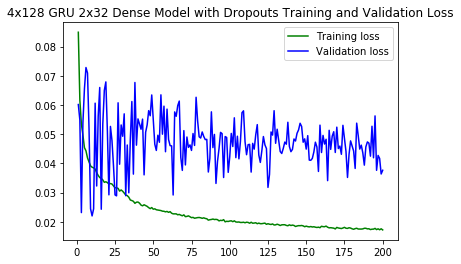

In [47]:
train_loss = []
val_loss = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (val_loss[-1] * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.834166
Validation MAE = 4.005036


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

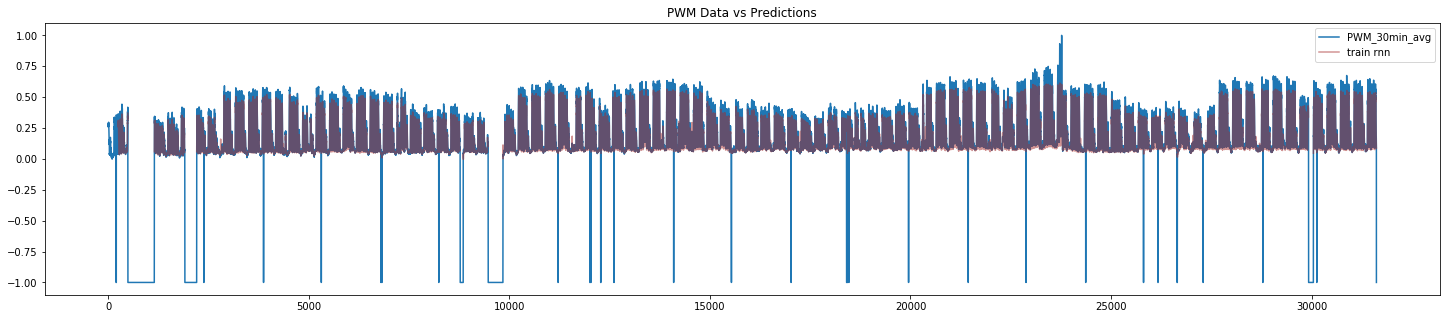

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

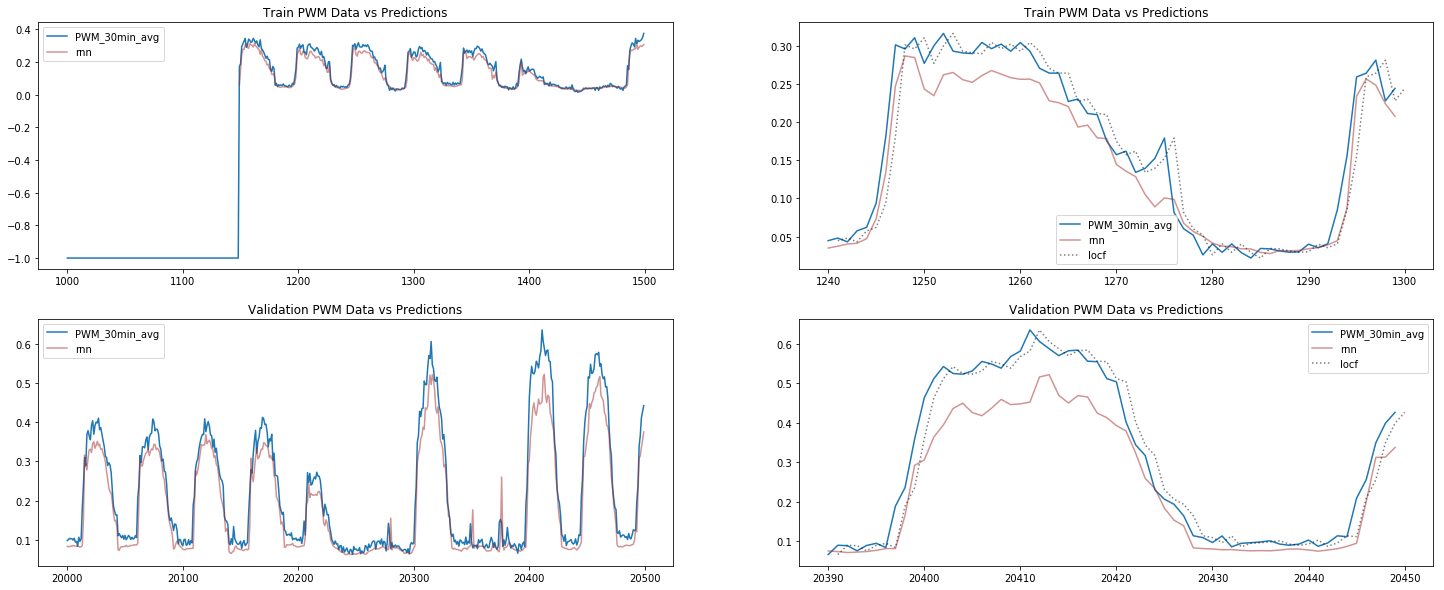

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0202.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and No Recurrent Dropout

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])


In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [33]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


 - 86s - loss: 0.0843 - mean_absolute_percentage_error: 51.2702 - val_loss: 0.0604 - val_mean_absolute_percentage_error: 23.5358


Epoch 2/50


 - 83s - loss: 0.0605 - mean_absolute_percentage_error: 37.4005 - val_loss: 0.0900 - val_mean_absolute_percentage_error: 38.3364


Epoch 3/50


 - 83s - loss: 0.0513 - mean_absolute_percentage_error: 30.8312 - val_loss: 0.0938 - val_mean_absolute_percentage_error: 30.6236


Epoch 4/50


 - 83s - loss: 0.0475 - mean_absolute_percentage_error: 29.5986 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 12.9550


Epoch 5/50


 - 83s - loss: 0.0444 - mean_absolute_percentage_error: 28.0224 - val_loss: 0.0522 - val_mean_absolute_percentage_error: 18.3554


Epoch 6/50


 - 83s - loss: 0.0426 - mean_absolute_percentage_error: 26.0586 - val_loss: 0.0737 - val_mean_absolute_percentage_error: 29.8102


Epoch 7/50


 - 83s - loss: 0.0407 - mean_absolute_percentage_error: 25.3983 - val_loss: 0.0558 - val_mean_absolute_percentage_error: 20.8350


Epoch 8/50


 - 83s - loss: 0.0391 - mean_absolute_percentage_error: 24.6472 - val_loss: 0.0423 - val_mean_absolute_percentage_error: 15.6414


Epoch 9/50


 - 83s - loss: 0.0383 - mean_absolute_percentage_error: 23.4407 - val_loss: 0.0577 - val_mean_absolute_percentage_error: 19.5284


Epoch 10/50


 - 83s - loss: 0.0385 - mean_absolute_percentage_error: 23.7500 - val_loss: 0.0609 - val_mean_absolute_percentage_error: 25.8534


Epoch 11/50


 - 83s - loss: 0.0371 - mean_absolute_percentage_error: 23.3094 - val_loss: 0.0666 - val_mean_absolute_percentage_error: 36.9750


Epoch 12/50


 - 83s - loss: 0.0361 - mean_absolute_percentage_error: 22.3282 - val_loss: 0.0657 - val_mean_absolute_percentage_error: 23.2774


Epoch 13/50


 - 83s - loss: 0.0360 - mean_absolute_percentage_error: 22.2000 - val_loss: 0.0512 - val_mean_absolute_percentage_error: 17.4286


Epoch 14/50


 - 83s - loss: 0.0348 - mean_absolute_percentage_error: 21.5192 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 16.2361


Epoch 15/50


 - 83s - loss: 0.0349 - mean_absolute_percentage_error: 22.1125 - val_loss: 0.0510 - val_mean_absolute_percentage_error: 19.5550


Epoch 16/50


 - 83s - loss: 0.0342 - mean_absolute_percentage_error: 20.9820 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 13.8315


Epoch 17/50


 - 83s - loss: 0.0333 - mean_absolute_percentage_error: 20.8801 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 11.0898


Epoch 18/50


 - 83s - loss: 0.0327 - mean_absolute_percentage_error: 20.2440 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 17.3859


Epoch 19/50


 - 85s - loss: 0.0334 - mean_absolute_percentage_error: 20.5952 - val_loss: 0.0404 - val_mean_absolute_percentage_error: 15.3736


Epoch 20/50


 - 85s - loss: 0.0329 - mean_absolute_percentage_error: 20.3886 - val_loss: 0.0378 - val_mean_absolute_percentage_error: 16.3871


Epoch 21/50


 - 84s - loss: 0.0376 - mean_absolute_percentage_error: 23.8015 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 22.0442


Epoch 22/50


 - 84s - loss: 0.0342 - mean_absolute_percentage_error: 21.8398 - val_loss: 0.0690 - val_mean_absolute_percentage_error: 26.9841


Epoch 23/50


 - 85s - loss: 0.0337 - mean_absolute_percentage_error: 21.0538 - val_loss: 0.0434 - val_mean_absolute_percentage_error: 15.3387


Epoch 24/50


 - 85s - loss: 0.0329 - mean_absolute_percentage_error: 20.8729 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 17.8164


Epoch 25/50


 - 85s - loss: 0.0323 - mean_absolute_percentage_error: 20.3077 - val_loss: 0.0584 - val_mean_absolute_percentage_error: 25.5282


Epoch 26/50


 - 84s - loss: 0.0315 - mean_absolute_percentage_error: 20.0363 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 16.0936


Epoch 27/50


 - 85s - loss: 0.0317 - mean_absolute_percentage_error: 19.5229 - val_loss: 0.0504 - val_mean_absolute_percentage_error: 19.6571


Epoch 28/50


 - 85s - loss: 0.0304 - mean_absolute_percentage_error: 19.4600 - val_loss: 0.0588 - val_mean_absolute_percentage_error: 25.3281


Epoch 29/50


 - 84s - loss: 0.0310 - mean_absolute_percentage_error: 19.9300 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 26.3116


Epoch 30/50


 - 84s - loss: 0.0298 - mean_absolute_percentage_error: 19.3300 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 24.4304


Epoch 31/50


 - 84s - loss: 0.0301 - mean_absolute_percentage_error: 18.4762 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 12.8372


Epoch 32/50


 - 84s - loss: 0.0290 - mean_absolute_percentage_error: 19.5472 - val_loss: 0.0410 - val_mean_absolute_percentage_error: 17.5324


Epoch 33/50


 - 84s - loss: 0.0276 - mean_absolute_percentage_error: 18.2582 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 17.1851


Epoch 34/50


 - 83s - loss: 0.0275 - mean_absolute_percentage_error: 18.5622 - val_loss: 0.0418 - val_mean_absolute_percentage_error: 14.7201


Epoch 35/50


 - 84s - loss: 0.0266 - mean_absolute_percentage_error: 17.4813 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 13.0639


Epoch 36/50


 - 83s - loss: 0.0266 - mean_absolute_percentage_error: 17.7711 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 14.1038


Epoch 37/50


 - 84s - loss: 0.0263 - mean_absolute_percentage_error: 17.8682 - val_loss: 0.0391 - val_mean_absolute_percentage_error: 13.6441


Epoch 38/50


 - 84s - loss: 0.0261 - mean_absolute_percentage_error: 17.3668 - val_loss: 0.0605 - val_mean_absolute_percentage_error: 23.5638


Epoch 39/50


 - 83s - loss: 0.0259 - mean_absolute_percentage_error: 17.1317 - val_loss: 0.0530 - val_mean_absolute_percentage_error: 28.4602


Epoch 40/50


 - 84s - loss: 0.0251 - mean_absolute_percentage_error: 16.7785 - val_loss: 0.0482 - val_mean_absolute_percentage_error: 18.9078


Epoch 41/50


 - 84s - loss: 0.0249 - mean_absolute_percentage_error: 16.3542 - val_loss: 0.0472 - val_mean_absolute_percentage_error: 19.7575


Epoch 42/50


 - 83s - loss: 0.0251 - mean_absolute_percentage_error: 16.8395 - val_loss: 0.0574 - val_mean_absolute_percentage_error: 32.9547


Epoch 43/50


 - 85s - loss: 0.0251 - mean_absolute_percentage_error: 16.9345 - val_loss: 0.0438 - val_mean_absolute_percentage_error: 17.6786


Epoch 44/50


 - 84s - loss: 0.0245 - mean_absolute_percentage_error: 16.6915 - val_loss: 0.0621 - val_mean_absolute_percentage_error: 24.4204


Epoch 45/50


 - 84s - loss: 0.0243 - mean_absolute_percentage_error: 15.9617 - val_loss: 0.0416 - val_mean_absolute_percentage_error: 17.0350


Epoch 46/50


 - 84s - loss: 0.0242 - mean_absolute_percentage_error: 16.1228 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 20.2262


Epoch 47/50


 - 83s - loss: 0.0241 - mean_absolute_percentage_error: 16.3502 - val_loss: 0.0555 - val_mean_absolute_percentage_error: 21.1506


Epoch 48/50


 - 84s - loss: 0.0239 - mean_absolute_percentage_error: 15.9494 - val_loss: 0.0401 - val_mean_absolute_percentage_error: 15.9559


Epoch 49/50


 - 83s - loss: 0.0233 - mean_absolute_percentage_error: 15.7773 - val_loss: 0.0449 - val_mean_absolute_percentage_error: 20.0717


Epoch 50/50


 - 83s - loss: 0.0233 - mean_absolute_percentage_error: 15.6599 - val_loss: 0.0463 - val_mean_absolute_percentage_error: 18.5381



Training Duration = 1:09:49.210190


In [25]:
histories.append(history.history)

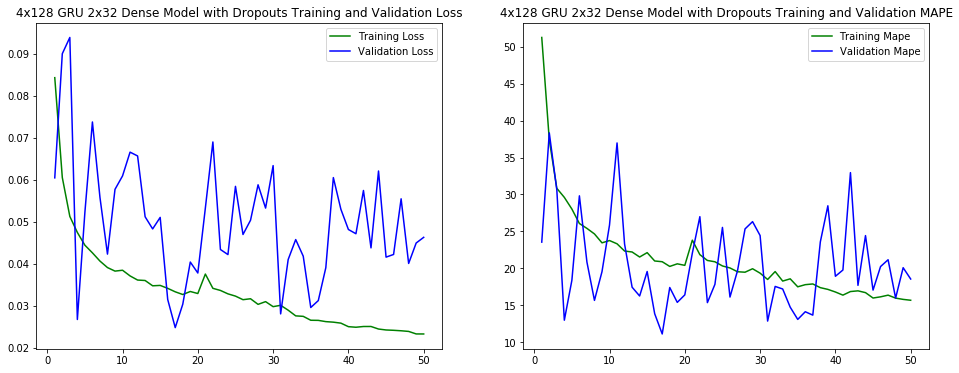

In [38]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.480317
Validation MAE = 2.641168


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

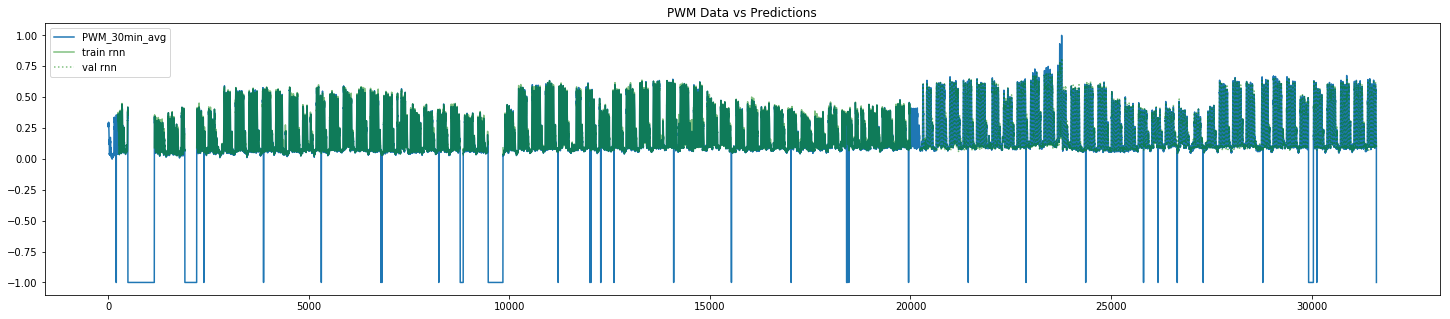

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

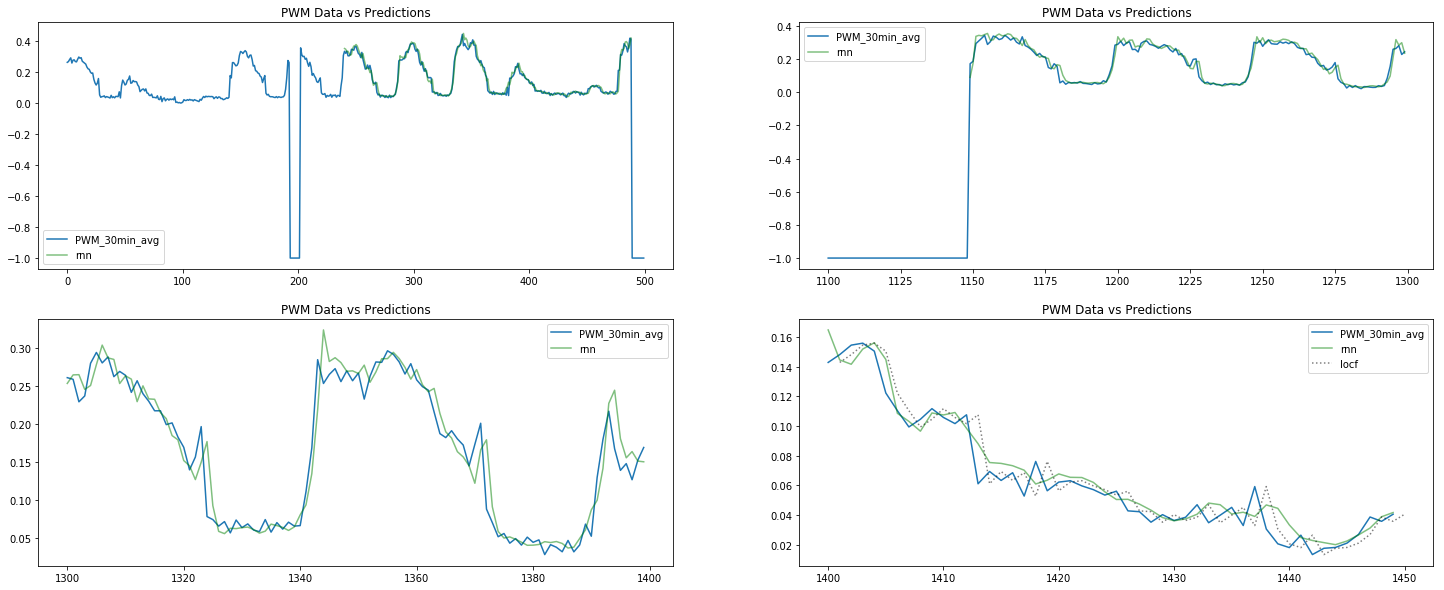

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [27]:
model.save('base-4x128gru-2x32dense-dropout0200.h5')

In [28]:
with open('base-4x128gru-2x32dense-dropout0200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with No Dropout and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002.h5'))
model.summary()

In [49]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


Epoch 1/50


Epoch 1/50


 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8200 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.8066


Epoch 2/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.5927 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3073


Epoch 3/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.7837 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.6431


Epoch 4/50


 - 88s - loss: 0.0156 - mean_absolute_percentage_error: 10.8850 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.6518


Epoch 5/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.9558 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.6858


Epoch 6/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.7372 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.1714


Epoch 7/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.7732 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 13.9883


Epoch 8/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.8325 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.8525


Epoch 9/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6818 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.5478


Epoch 10/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.5877 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.5059


Epoch 11/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6209 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.0055


Epoch 12/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6874 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.8163


Epoch 13/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.7618 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.6641


Epoch 14/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.8102 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.0553


Epoch 15/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.3616 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.6982


Epoch 16/50


 - 86s - loss: 0.0152 - mean_absolute_percentage_error: 10.7154 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.9173


Epoch 17/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.5983 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.4649


Epoch 18/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.4986 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.0330


Epoch 19/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.5215 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 8.7426


Epoch 20/50


 - 88s - loss: 0.0150 - mean_absolute_percentage_error: 10.4415 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2467


Epoch 21/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4082 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.1361


Epoch 22/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.3721 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.8795


Epoch 23/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.3732 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.9106


Epoch 24/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.2422 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.3097


Epoch 25/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4804 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.3111


Epoch 26/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.2715 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 11.2292


Epoch 27/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.4135 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 8.9801


Epoch 28/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2207 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.8305


Epoch 29/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2066 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.1136


Epoch 30/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.0973 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 12.1086


Epoch 31/50


 - 86s - loss: 0.0148 - mean_absolute_percentage_error: 10.2487 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.3236


Epoch 32/50


 - 86s - loss: 0.0146 - mean_absolute_percentage_error: 10.0608 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 10.5951


Epoch 33/50


 - 87s - loss: 0.0146 - mean_absolute_percentage_error: 10.1042 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.2985


Epoch 34/50


 - 86s - loss: 0.0147 - mean_absolute_percentage_error: 10.2127 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.8472


Epoch 35/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.1127 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.3444


Epoch 36/50


 - 87s - loss: 0.0145 - mean_absolute_percentage_error: 9.9344 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4945


Epoch 37/50


 - 86s - loss: 0.0145 - mean_absolute_percentage_error: 10.0337 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2990


Epoch 38/50


 - 86s - loss: 0.0144 - mean_absolute_percentage_error: 10.2033 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9608


Epoch 39/50


 - 87s - loss: 0.0144 - mean_absolute_percentage_error: 10.0721 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.2719


Epoch 40/50


 - 88s - loss: 0.0145 - mean_absolute_percentage_error: 10.2058 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 10.1445


Epoch 41/50


 - 88s - loss: 0.0144 - mean_absolute_percentage_error: 9.9969 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.9810


Epoch 42/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.9378 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 9.0890


Epoch 43/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9270 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.5699


Epoch 44/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8470 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4775


Epoch 45/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9480 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.6116


Epoch 46/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.8142 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.4486


Epoch 47/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8870 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.4787


Epoch 48/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.7393 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.8748


Epoch 49/50


 - 87s - loss: 0.0140 - mean_absolute_percentage_error: 9.7657 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.9728


Epoch 50/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 10.0320 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.9776



Training Duration = 1:12:26.506771


In [50]:
# histories = []  ## if first training session
histories.append(history.history)

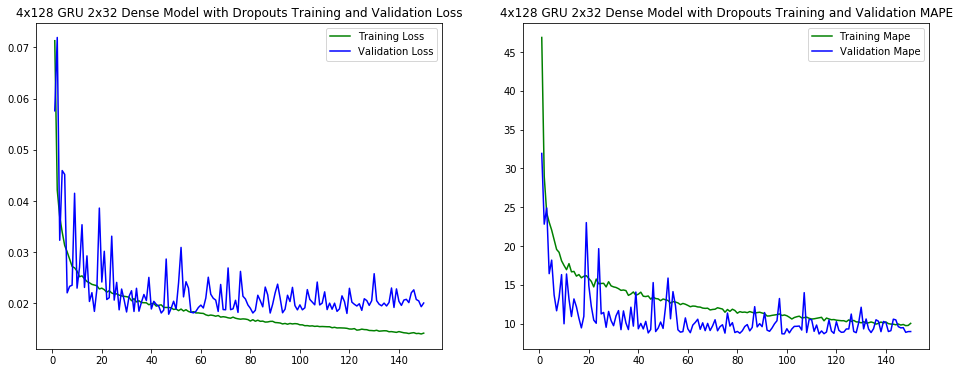

In [51]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.493735
Validation MAE = 1.904215


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

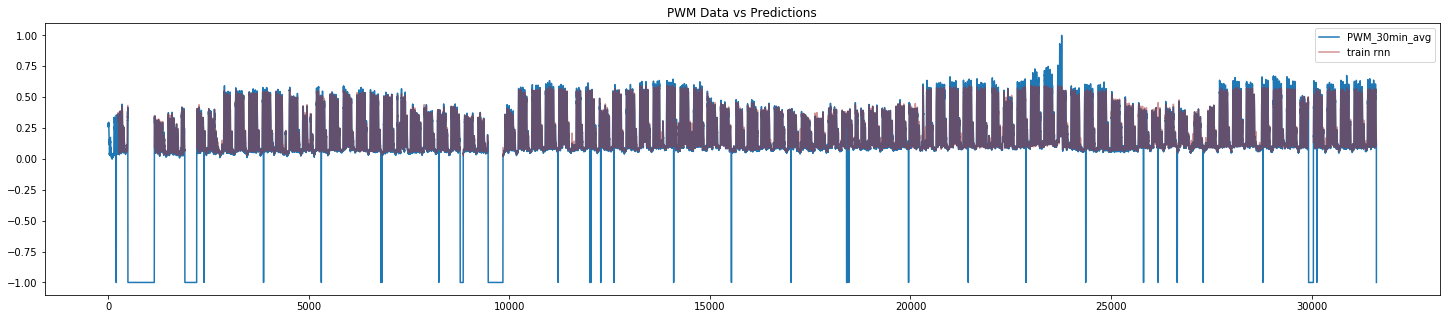

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

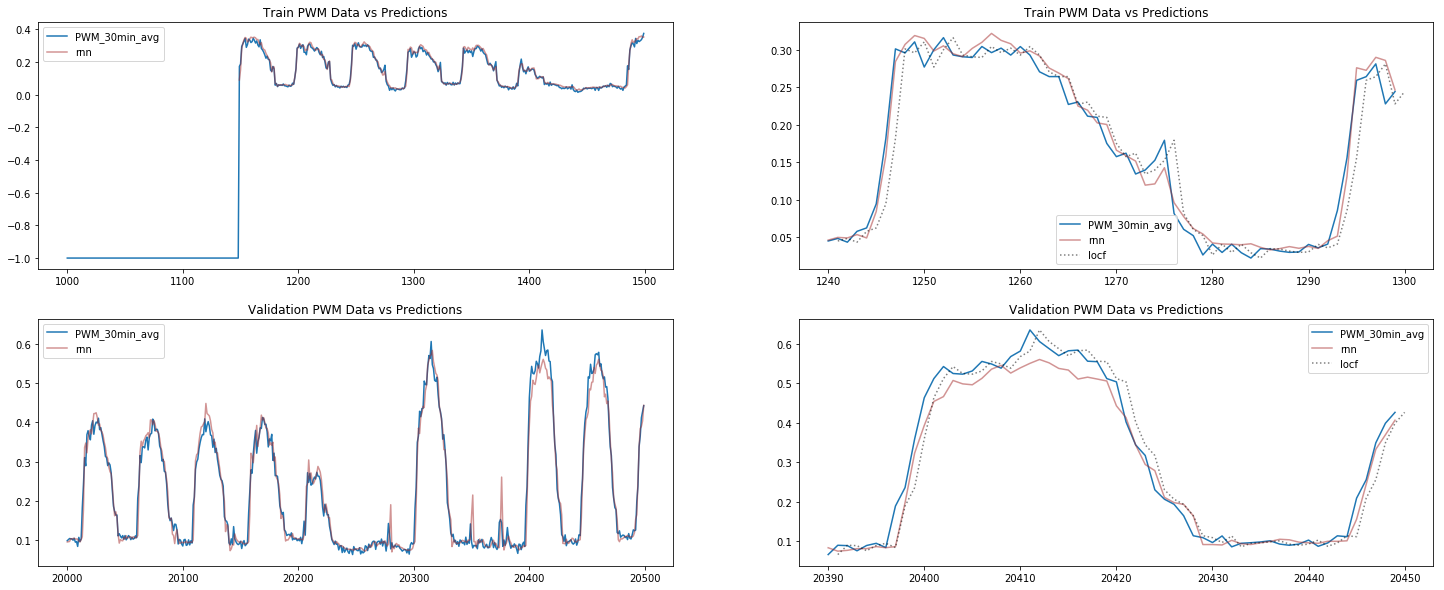

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0002.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0002-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)